#Pre-processing

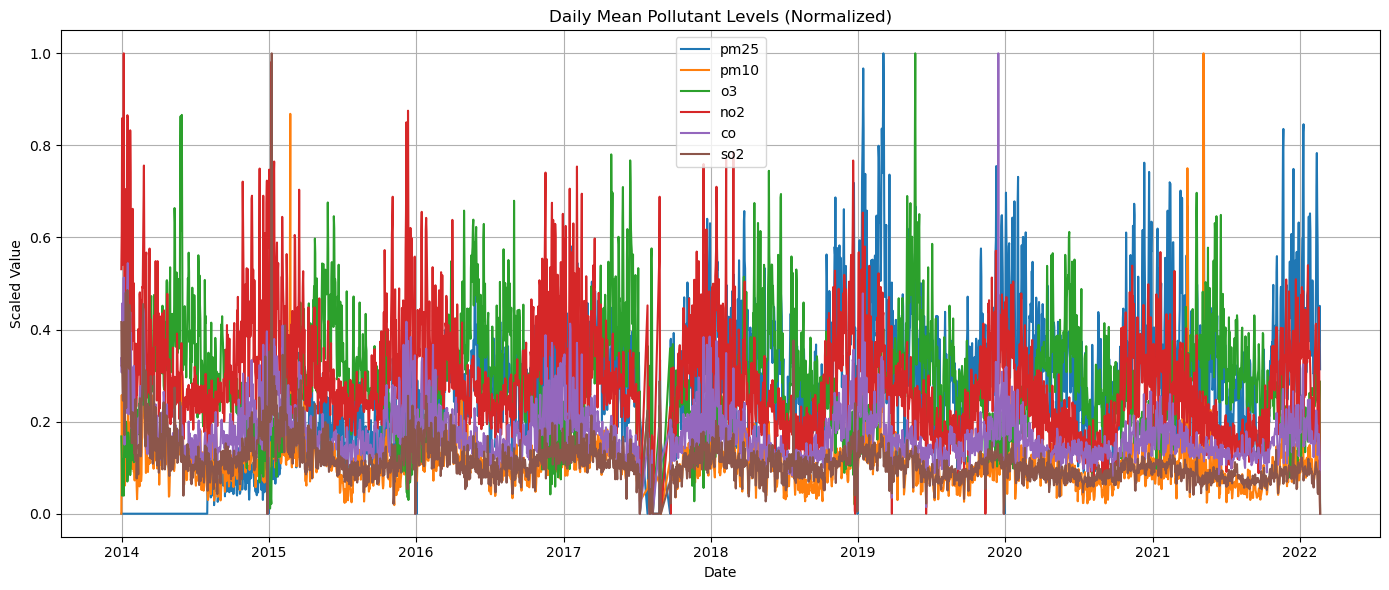

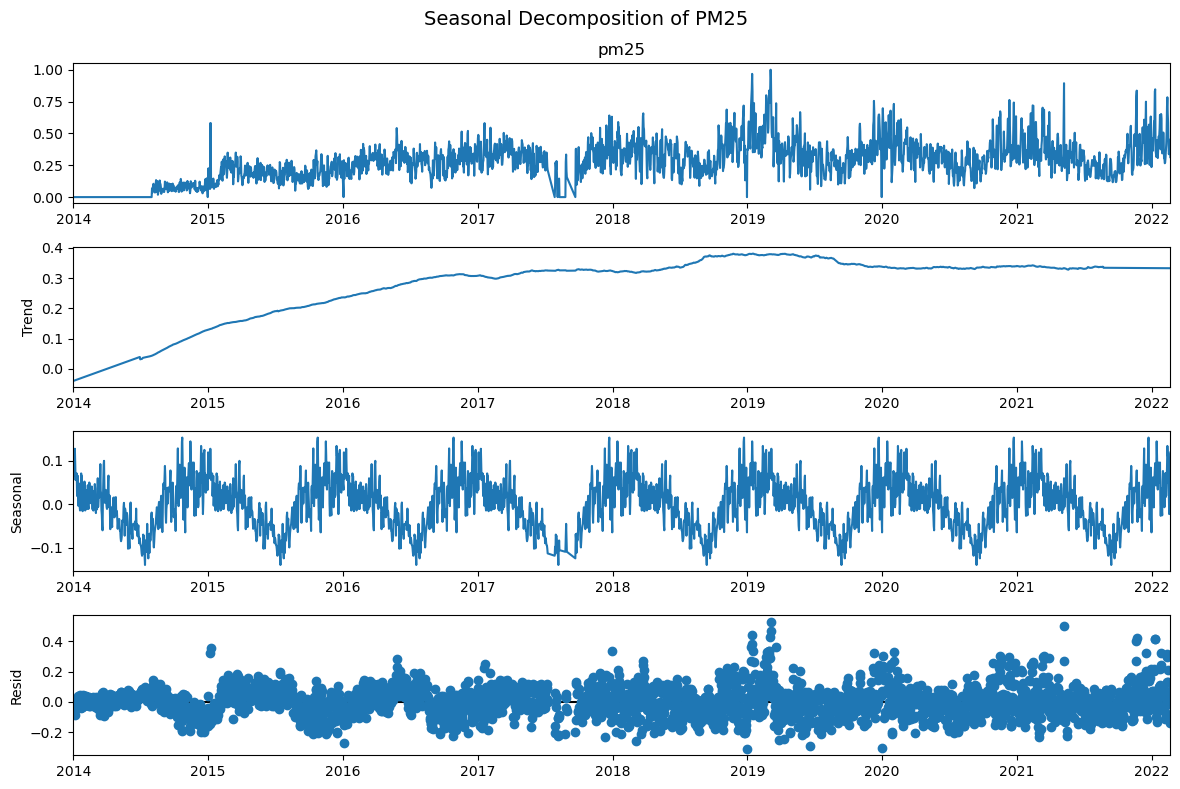

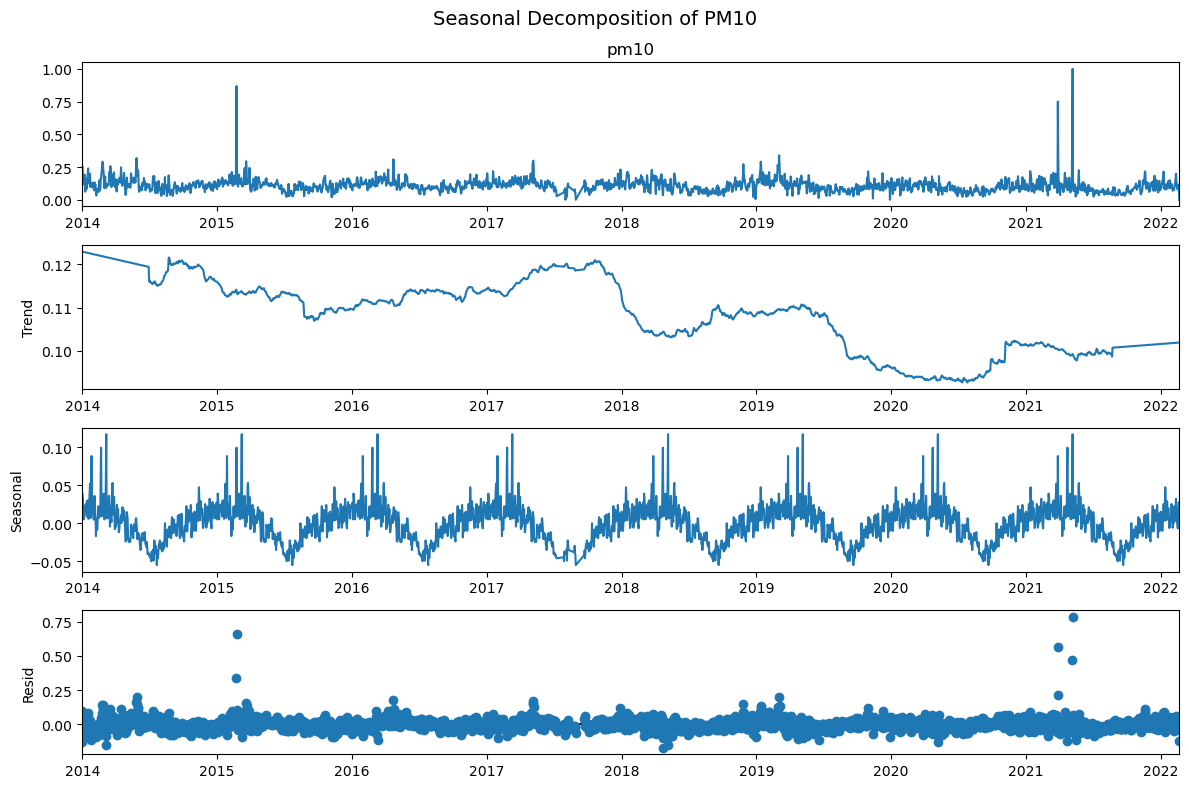

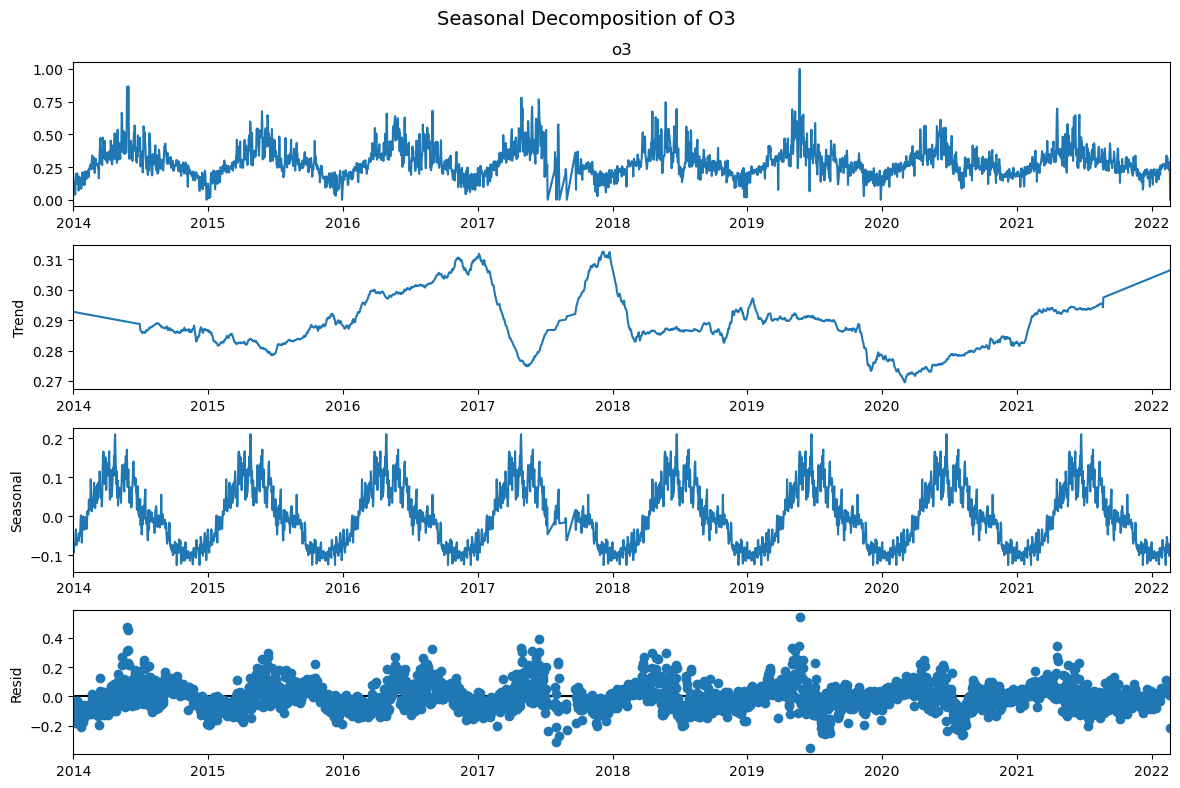

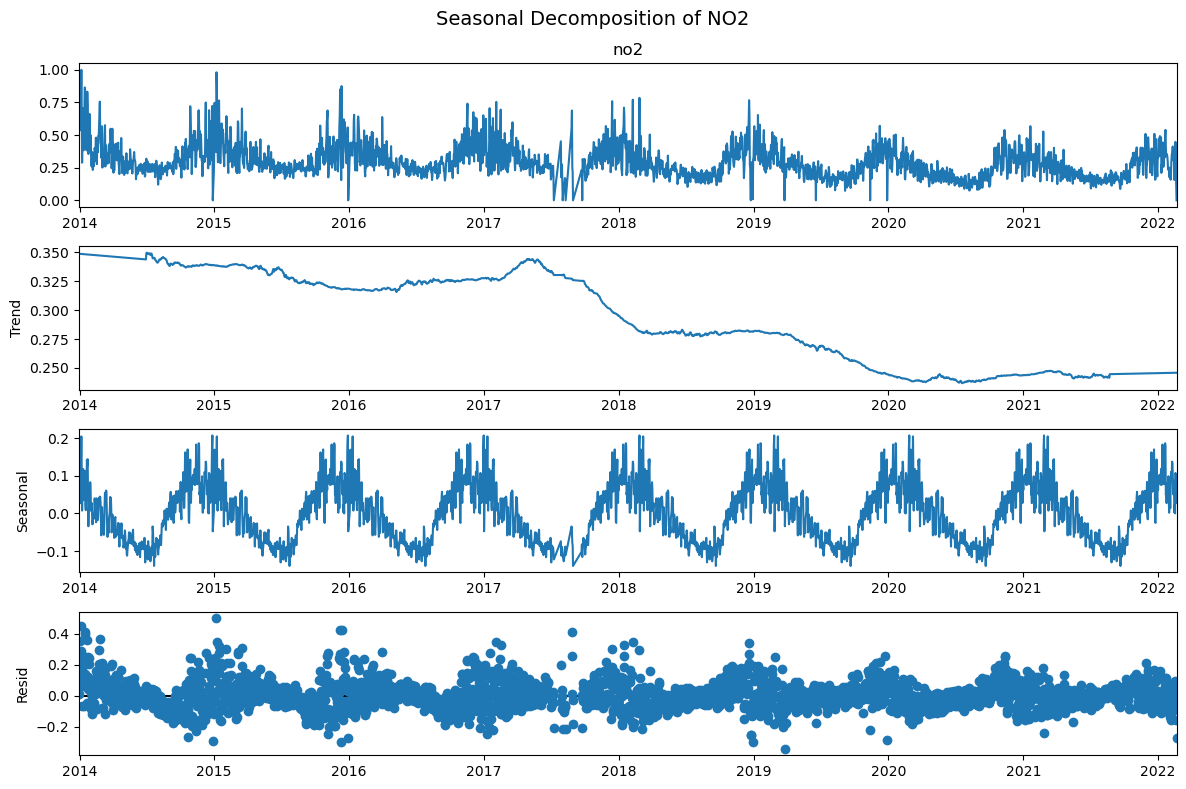

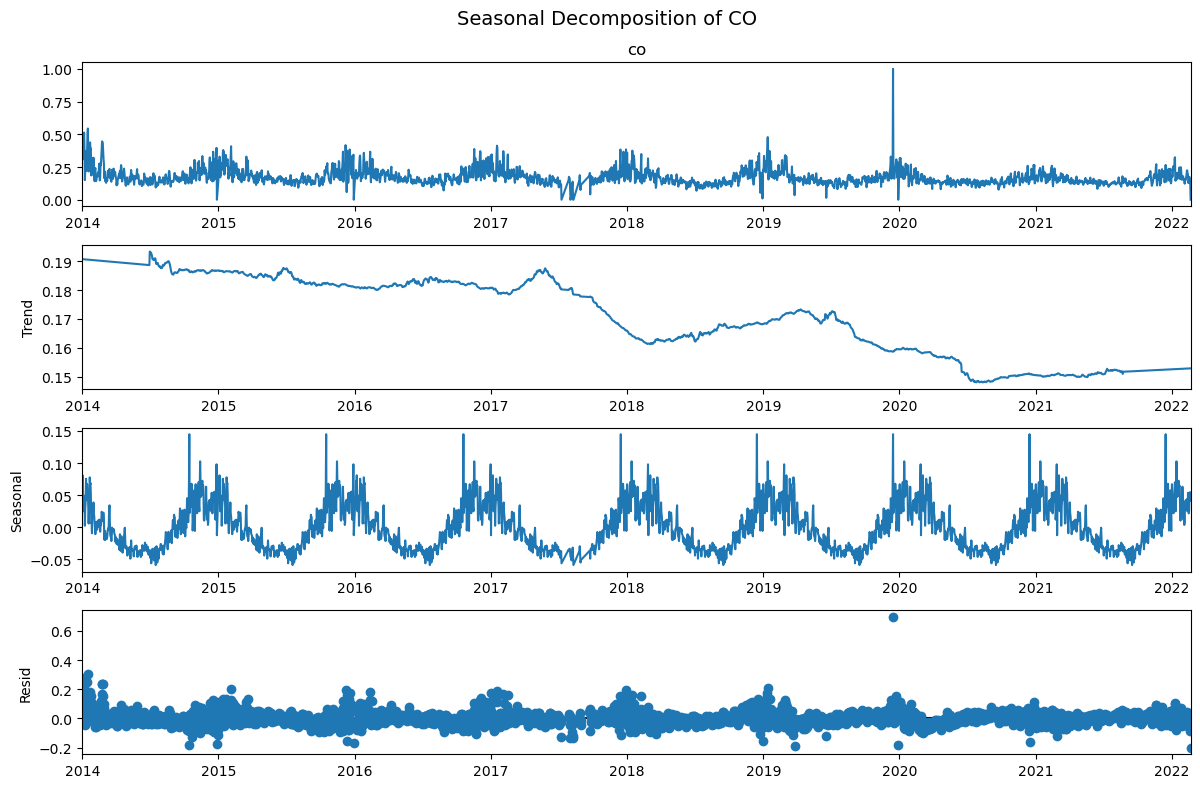

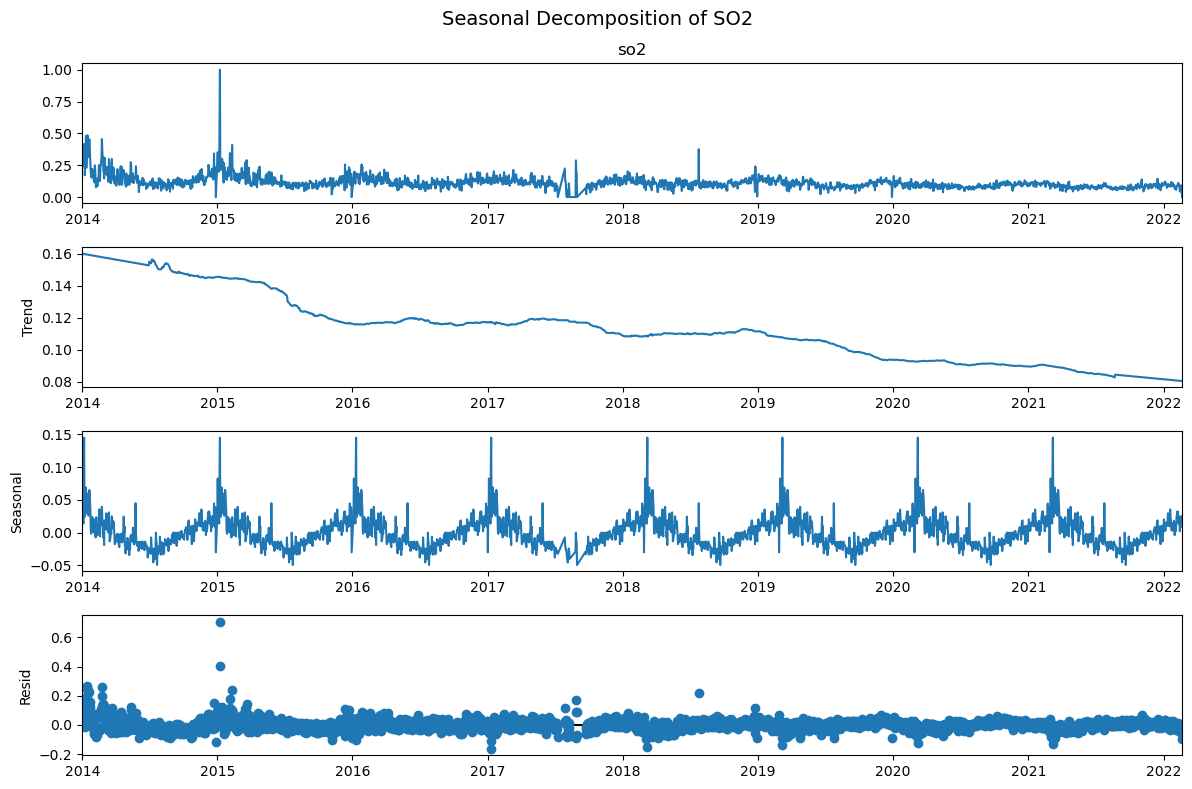

Train shape: (2328, 6)
Test shape: (583, 6)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("south-korean-pollution-data.csv", parse_dates=["date"])
df = df.sort_values("date")

pollutants = ["pm25", "pm10", "o3", "no2", "co", "so2"]

# Interpolate missing values
df[pollutants] = df[pollutants].interpolate(method="linear")

# Outlier removal for error spikes
# Compute mean and std over the whole series
#  If current value is outside [mean - std, mean + std] and both previous and next values are inside that band = outlier
for col in pollutants:
    series = df[col]
    mean = series.mean()
    std = series.std()

    lower = mean - std
    upper = mean + std

    prev_inside = series.shift(1).between(lower, upper)
    next_inside = series.shift(-1).between(lower, upper)
    current_outside = ~series.between(lower, upper)

    outlier_mask = current_outside & prev_inside & next_inside

    df.loc[outlier_mask, col] = np.nan

# Interpolate again after outlier removal
df[pollutants] = df[pollutants].interpolate(method="linear")

# Drop unneeded columns
drop_cols = ["latitude", "longitude", "Lat", "Long", "city", "country"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Aggregate daily mean across all stations
df_daily = df.groupby("date")[pollutants].mean().reset_index()

# Normalize pollutants (MinMaxScaler on daily means)
scaler = MinMaxScaler()
df_daily[pollutants] = scaler.fit_transform(df_daily[pollutants])

# Set date as index for time-series operations
df_daily = df_daily.set_index("date")

# Plot daily mean pollutants
plt.figure(figsize=(14, 6))
for col in pollutants:
    plt.plot(df_daily.index, df_daily[col], label=col)
plt.title("Daily Mean Pollutant Levels (Normalized)")
plt.xlabel("Date")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Time-series decomposition per pollutant
decompositions = {}

for col in pollutants:
    series = df_daily[col]

    decomposition = sm.tsa.seasonal_decompose(
        series,
        model='additive',
        period=365,
        extrapolate_trend="freq"
    )
    decompositions[col] = decomposition

    # Plot
    fig = decomposition.plot()
    fig.set_size_inches(12, 8)
    plt.suptitle(f"Seasonal Decomposition of {col.upper()}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Train test split (80/20) on processed daily data
split_idx = int(len(df_daily) * 0.8)
train = df_daily.iloc[:split_idx]
test = df_daily.iloc[split_idx:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)


#LSTM Model + HPO


Trial 1/30 -> {'hidden': 32, 'layers': 3, 'drop': 0.0, 'lr': 0.005, 'batch': 32}
Epoch 01 | Train MSE = 0.0171 | Val MSE = 0.0097
Epoch 02 | Train MSE = 0.0076 | Val MSE = 0.0051
Epoch 03 | Train MSE = 0.0059 | Val MSE = 0.0050
Epoch 04 | Train MSE = 0.0058 | Val MSE = 0.0051
Epoch 05 | Train MSE = 0.0057 | Val MSE = 0.0049
Epoch 06 | Train MSE = 0.0055 | Val MSE = 0.0047
Epoch 07 | Train MSE = 0.0055 | Val MSE = 0.0048
Epoch 08 | Train MSE = 0.0054 | Val MSE = 0.0047
Epoch 09 | Train MSE = 0.0053 | Val MSE = 0.0047
Epoch 10 | Train MSE = 0.0053 | Val MSE = 0.0046
Val MAE: 0.04284804
Val RMSE: 0.06785156806172736

Trial 2/30 -> {'hidden': 128, 'layers': 3, 'drop': 0.0, 'lr': 0.001, 'batch': 64}
Epoch 01 | Train MSE = 0.0157 | Val MSE = 0.0087
Epoch 02 | Train MSE = 0.0101 | Val MSE = 0.0087
Epoch 03 | Train MSE = 0.0084 | Val MSE = 0.0061
Epoch 04 | Train MSE = 0.0061 | Val MSE = 0.0049
Epoch 05 | Train MSE = 0.0059 | Val MSE = 0.0045
Epoch 06 | Train MSE = 0.0058 | Val MSE = 0.0051
E

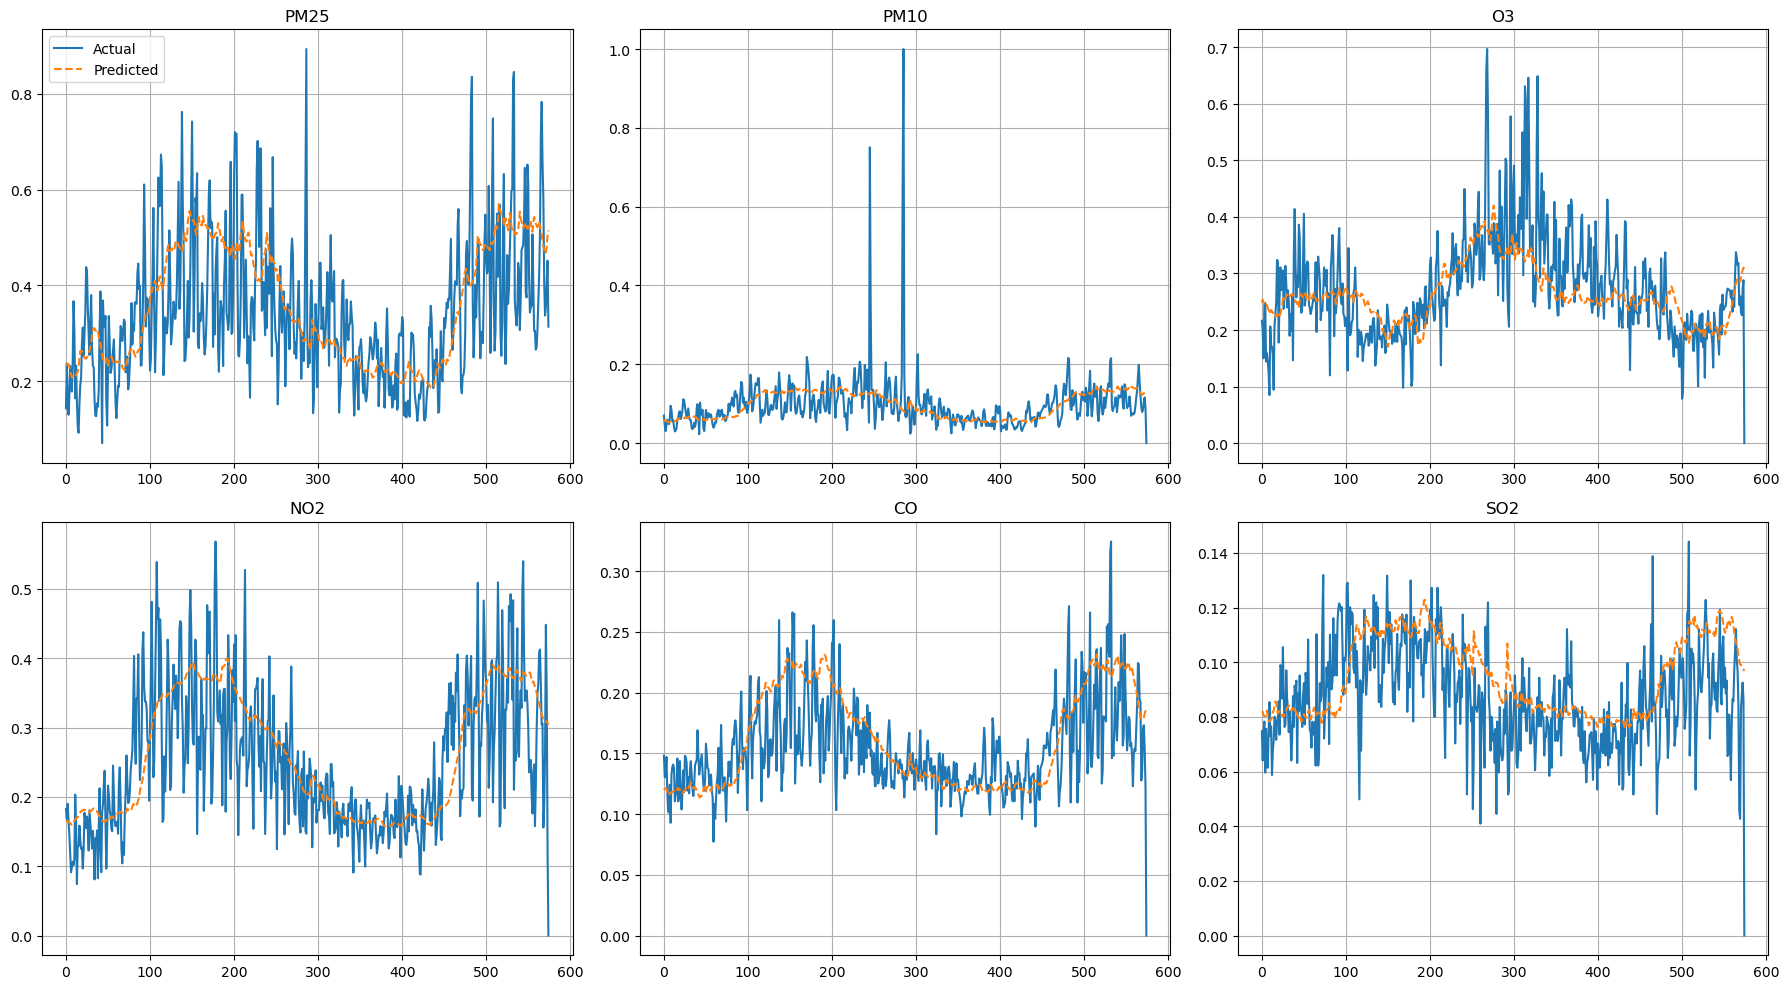

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import random, math

# Sliding window time-series
class SeqDataset(Dataset):
    def __init__(self, X, y):
        # storing windows and targets as tensors
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        # return one sample (window and label)
        return self.X[i], self.y[i]


# Build sliding windows + split into train/val/test
def make_loaders(df_daily, window=30, horizon=7, batch=64):

    data = df_daily.values
    X, y = [], []

    # standard sliding window setup
    for i in range(len(data) - window - horizon + 1):
        X.append(data[i:i + window])
        # target is the day at window+horizon-1
        y.append(data[i + window + horizon - 1])

    X = np.array(X)
    y = np.array(y)

    # time split: keep chronological order
    n = len(X)
    train_end = int(n * 0.7)
    val_end   = int(n * 0.8)

    loaders = {
        "train": DataLoader(SeqDataset(X[:train_end], y[:train_end]), batch_size=batch, shuffle=True),
        "val":   DataLoader(SeqDataset(X[train_end:val_end], y[train_end:val_end]), batch_size=batch, shuffle=False),
        "test":  DataLoader(SeqDataset(X[val_end:], y[val_end:]), batch_size=batch, shuffle=False)
    }

    # dimensions for model setup
    input_dim  = X.shape[-1]     # number of features (= pollutants)
    output_dim = y.shape[-1]     # same number of outputs

    return loaders, input_dim, output_dim


# LSTM model
class LSTM(nn.Module):
    def __init__(self, in_dim, hid, layers, out_dim, drop):
        super().__init__()

        # multi-layer LSTM; dropout only works when layers>1
        self.lstm = nn.LSTM(
            input_size=in_dim,
            hidden_size=hid,
            num_layers=layers,
            batch_first=True,
            dropout=drop if layers > 1 else 0.0
        )

        # final linear layer maps hidden state - predicted pollutant vector
        self.fc = nn.Linear(hid, out_dim)

    def forward(self, x):
        # LSTM outputs full sequence, but we only want the last timestep
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)


# One training loop
def train_one(model, loaders, lr=1e-3, epochs=8):
    # Adam chosen just because it's stable for time-series
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()  # regression task

    for ep in range(1, epochs + 1):
        model.train()
        tr_losses = []

        # train pass
        for xb, yb in loaders["train"]:
            opt.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            opt.step()
            tr_losses.append(loss.item())

        # validation pass
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in loaders["val"]:
                loss = loss_fn(model(xb), yb)
                val_losses.append(loss.item())

        print(
            f"Epoch {ep:02d} | "
            f"Train MSE = {np.mean(tr_losses):.4f} | "
            f"Val MSE = {np.mean(val_losses):.4f}"
        )

    return model


# Evaluate model
def eval_model(model, loader):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for xb, yb in loader:
            preds.append(model(xb).numpy())
            targets.append(yb.numpy())

    preds = np.vstack(preds)
    targets = np.vstack(targets)

    mae  = mean_absolute_error(targets, preds)
    rmse = math.sqrt(mean_squared_error(targets, preds))
    return mae, rmse


# Random hyperparameter generator
def random_params():
    """
    Random search space for LSTM.
    Values kept small because dataset isn't huge.
    """
    return {
        "hidden": random.choice([32, 64, 128]),
        "layers": random.choice([1, 2, 3]),
        "drop":   random.choice([0.0, 0.2, 0.4]),
        "lr":     random.choice([1e-2, 5e-3, 1e-3]),
        "batch":  random.choice([32, 64, 128])
    }


# Run random search HPO
def hpo_lstm(df_daily, trials=6, window=30, horizon=7):

    best_rmse = float("inf")
    best_mae = float("inf")
    best_params = None
    best_state = None

    for t in range(1, trials + 1):
        params = random_params()
        print(f"\nTrial {t}/{trials} -> {params}")

        loaders, in_dim, out_dim = make_loaders(df_daily, window, horizon, params["batch"])

        model = LSTM(in_dim, params["hidden"], params["layers"], out_dim, params["drop"])

        # shorter training because HPO repeats this many times
        train_one(model, loaders, lr=params["lr"], epochs=10)

        val_mae, val_rmse = eval_model(model, loaders["val"])

        print("Val MAE:", val_mae)
        print("Val RMSE:", val_rmse)

        # keep best params
        if val_rmse < best_rmse:
            best_rmse   = val_rmse
            best_mae    = val_mae
            best_params = params
            best_state  = model.state_dict()

    print("\nBest config found:", best_params)
    print("Best validation RMSE:", best_rmse)
    print("Best validation MAE:", best_mae)

    # after HPO, retrain best model longer
    loaders, in_dim, out_dim = make_loaders(df_daily, window, horizon, best_params["batch"])
    best_model = LSTM(in_dim, best_params["hidden"], best_params["layers"], out_dim, best_params["drop"])
    best_model.load_state_dict(best_state)

    train_one(best_model, loaders, lr=best_params["lr"], epochs=20)

    # final evaluation
    test_mae, test_rmse = eval_model(best_model, loaders["test"])
    print("\nTest MAE:", test_mae)
    print("Test RMSE:", test_rmse)

    return best_model, best_params, best_rmse, best_mae   # <--- RETURN MAE


# Run HPO (fixed unpacking)
best_model, best_params, best_val_rmse, best_val_mae = hpo_lstm(
    df_daily=df_daily,
    trials=30,
    window=30,
    horizon=7
)

print("Best params:", best_params)
print("Best validation RMSE:", best_val_rmse)
print("Best validation MAE:", best_val_mae)


# Plot predicted vs actual for all pollutants
import matplotlib.pyplot as plt

def plot_all_pollutants(model, df_daily, window=30, horizon=7, batch=64):
    # rebuild dataset with final batch size
    loaders, _, _ = make_loaders(df_daily, window, horizon, batch)

    preds, reals = [], []

    with torch.no_grad():
        for xb, yb in loaders["test"]:
            preds.append(model(xb).numpy())
            reals.append(yb.numpy())

    preds = np.vstack(preds)
    reals = np.vstack(reals)

    names = list(df_daily.columns)

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    # one subplot per pollutant
    for i in range(6):
        ax = axes[i]
        ax.plot(reals[:, i], label="Actual")
        ax.plot(preds[:, i], linestyle="dashed", label="Predicted")
        ax.set_title(names[i].upper())
        ax.grid(True)

    axes[0].legend()
    plt.tight_layout()
    plt.show()

    return preds, reals


preds, reals = plot_all_pollutants(
    best_model,
    df_daily,
    batch=best_params["batch"]
)


#GRU Model + HPO


GRU Trial 1/30 — {'hidden': 128, 'layers': 3, 'drop': 0.4, 'lr': 0.01, 'batch': 32}
Epoch 01 | Train MSE=0.0128 | Val MSE=0.0051
Epoch 02 | Train MSE=0.0061 | Val MSE=0.0061
Epoch 03 | Train MSE=0.0063 | Val MSE=0.0046
Epoch 04 | Train MSE=0.0059 | Val MSE=0.0046
Epoch 05 | Train MSE=0.0060 | Val MSE=0.0054
Epoch 06 | Train MSE=0.0056 | Val MSE=0.0048
Epoch 07 | Train MSE=0.0056 | Val MSE=0.0048
Epoch 08 | Train MSE=0.0055 | Val MSE=0.0046
Epoch 09 | Train MSE=0.0055 | Val MSE=0.0051
Epoch 10 | Train MSE=0.0054 | Val MSE=0.0048
Val MAE: 0.04614668
Val RMSE: 0.06899508119928749

GRU Trial 2/30 — {'hidden': 64, 'layers': 1, 'drop': 0.4, 'lr': 0.005, 'batch': 32}
Epoch 01 | Train MSE=0.0102 | Val MSE=0.0048
Epoch 02 | Train MSE=0.0058 | Val MSE=0.0048
Epoch 03 | Train MSE=0.0057 | Val MSE=0.0044
Epoch 04 | Train MSE=0.0055 | Val MSE=0.0045
Epoch 05 | Train MSE=0.0055 | Val MSE=0.0048
Epoch 06 | Train MSE=0.0054 | Val MSE=0.0044
Epoch 07 | Train MSE=0.0053 | Val MSE=0.0047
Epoch 08 | Trai

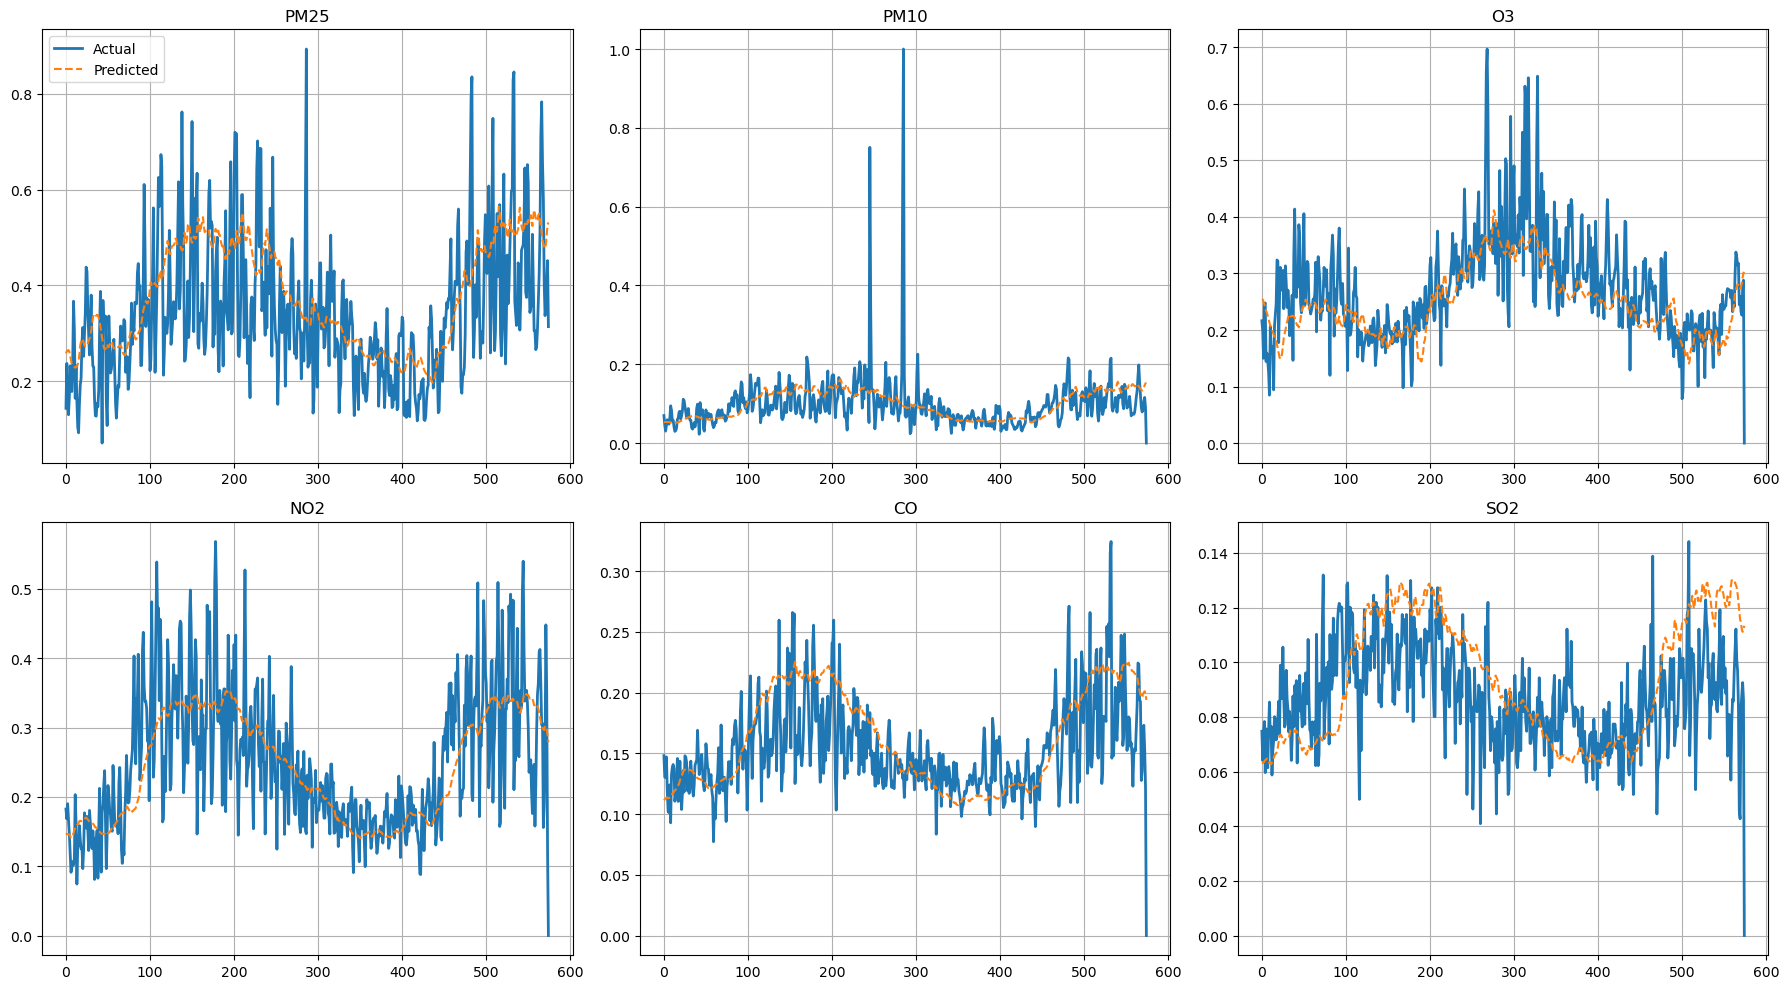

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import random, math

# Dataset class for sliding-window input
class SeqDataset(Dataset):
    def __init__(self, X, y):
        # store windows/targets as tensors for PyTorch
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        # return one (window, label) pair
        return self.X[i], self.y[i]


# Create sliding windows + split into train/val/test
def make_loaders(df_daily, window=30, horizon=7, batch=64):
    data = df_daily.values
    X, y = [], []

    # build X (window) and y (future target)
    for i in range(len(data) - window - horizon + 1):
        X.append(data[i:i + window])
        y.append(data[i + window + horizon - 1])

    X = np.array(X)
    y = np.array(y)

    n = len(X)
    train_end = int(n * 0.7)
    val_end   = int(n * 0.8)

    loaders = {
        "train": DataLoader(SeqDataset(X[:train_end], y[:train_end]), batch_size=batch, shuffle=True),
        "val":   DataLoader(SeqDataset(X[train_end:val_end], y[train_end:val_end]), batch_size=batch, shuffle=False),
        "test":  DataLoader(SeqDataset(X[val_end:], y[val_end:]), batch_size=batch, shuffle=False)
    }

    # model input/output sizes
    in_dim = X.shape[-1]
    out_dim = y.shape[-1]

    return loaders, in_dim, out_dim


# GRU model (same idea as LSTM but simpler gating)
class GRU(nn.Module):
    def __init__(self, in_dim, hid, layers, out_dim, drop):
        super().__init__()
        # stacked GRU layers
        self.gru = nn.GRU(
            input_size=in_dim,
            hidden_size=hid,
            num_layers=layers,
            batch_first=True,
            dropout=drop if layers > 1 else 0.0
        )
        # final dense layer to map hidden state → pollutant prediction
        self.fc = nn.Linear(hid, out_dim)

    def forward(self, x):
        # GRU outputs a full sequence; we take only the last hidden state
        out, _ = self.gru(x)
        out_last = out[:, -1, :]
        return self.fc(out_last)


# One training loop for GRU
def train_one(model, loaders, lr=1e-3, epochs=8):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for ep in range(1, epochs + 1):
        model.train()
        tr_loss = []

        # training pass
        for xb, yb in loaders["train"]:
            opt.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            opt.step()
            tr_loss.append(loss.item())

        # validation pass
        model.eval()
        val_loss = []
        with torch.no_grad():
            for xb, yb in loaders["val"]:
                preds = model(xb)
                val_loss.append(loss_fn(preds, yb).item())

        print(f"Epoch {ep:02d} | Train MSE={np.mean(tr_loss):.4f} | Val MSE={np.mean(val_loss):.4f}")

    return model


# Evaluate GRU on a dataset (MAE + RMSE)
def eval_model(model, loader):
    model.eval()
    preds, targs = [], []

    with torch.no_grad():
        for xb, yb in loader:
            out = model(xb).numpy()
            preds.append(out)
            targs.append(yb.numpy())

    preds = np.vstack(preds)
    targs = np.vstack(targs)

    mae = mean_absolute_error(targs, preds)
    rmse = math.sqrt(mean_squared_error(targs, preds))
    return mae, rmse


# Random hyperparameter sampler
def random_params():
    # same ranges as LSTM — keeps models comparable
    return {
        "hidden": random.choice([32, 64, 128]),
        "layers": random.choice([1, 2, 3]),
        "drop":   random.choice([0.0, 0.2, 0.4]),
        "lr":     random.choice([1e-2, 5e-3, 1e-3]),
        "batch":  random.choice([32, 64, 128])
    }


# Random search for best GRU config (now tracks MAE also)
def hpo_gru(df_daily, trials=30, window=30, horizon=7):

    best_rmse = float("inf")
    best_mae = float("inf")
    best_params = None
    best_state = None

    for t in range(1, trials + 1):
        params = random_params()
        print(f"\nGRU Trial {t}/{trials} — {params}")

        loaders, in_dim, out_dim = make_loaders(df_daily, window, horizon, params["batch"])

        model = GRU(in_dim, params["hidden"], params["layers"], out_dim, params["drop"])

        train_one(model, loaders, lr=params["lr"], epochs=10)

        val_mae, val_rmse = eval_model(model, loaders["val"])
        print("Val MAE:", val_mae)
        print("Val RMSE:", val_rmse)

        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_mae = val_mae
            best_params = params
            best_state = model.state_dict()

    print("\nBest GRU Params:", best_params)
    print("Best Validation RMSE:", best_rmse)
    print("Best Validation MAE:", best_mae)

    loaders, in_dim, out_dim = make_loaders(df_daily, window, horizon, best_params["batch"])
    best_model = GRU(in_dim, best_params["hidden"], best_params["layers"], out_dim, best_params["drop"])
    best_model.load_state_dict(best_state)

    train_one(best_model, loaders, lr=best_params["lr"], epochs=20)

    test_mae, test_rmse = eval_model(best_model, loaders["test"])
    print("\nTest MAE:", test_mae)
    print("Test RMSE:", test_rmse)

    return best_model, best_params, best_rmse, best_mae


best_gru, gru_params, gru_rmse, gru_mae = hpo_gru(
    df_daily=df_daily,
    trials=30,
    window=30,
    horizon=7
)

print("\nSelected GRU Params:", gru_params)
print("Best Validation RMSE:", gru_rmse)
print("Best Validation MAE:", gru_mae)


# Plot predictions vs true for all 6 pollutants
import matplotlib.pyplot as plt

def plot_all_pollutants_gru(best_model, df_daily, window=30, horizon=7, batch=64):
    loaders, in_dim, out_dim = make_loaders(df_daily, window, horizon, batch)

    preds, reals = [], []

    with torch.no_grad():
        for xb, yb in loaders["test"]:
            preds.append(best_model(xb).numpy())
            reals.append(yb.numpy())

    preds = np.vstack(preds)
    reals = np.vstack(reals)

    names = df_daily.columns
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i in range(6):
        ax = axes[i]
        ax.plot(reals[:, i], label="Actual", linewidth=2)
        ax.plot(preds[:, i], linestyle="dashed", label="Predicted")
        ax.set_title(names[i].upper())
        ax.grid(True)

    axes[0].legend()
    plt.tight_layout()
    plt.show()

    return preds, reals


preds_gru, reals_gru = plot_all_pollutants_gru(
    best_gru,
    df_daily,
    window=30,
    horizon=7,
    batch=gru_params["batch"]
)


#TCN Model + HPO


=== TCN Trial 1/30 ===
{'hidden': 32, 'layers': 3, 'drop': 0.0, 'lr': 0.001, 'batch': 64}
Epoch 01 | Train MSE=0.0424 | Val MSE=0.0131
Epoch 02 | Train MSE=0.0110 | Val MSE=0.0082
Epoch 03 | Train MSE=0.0087 | Val MSE=0.0070
Epoch 04 | Train MSE=0.0078 | Val MSE=0.0063
Epoch 05 | Train MSE=0.0073 | Val MSE=0.0061
Epoch 06 | Train MSE=0.0069 | Val MSE=0.0060
Epoch 07 | Train MSE=0.0066 | Val MSE=0.0058
Epoch 08 | Train MSE=0.0064 | Val MSE=0.0055
Epoch 09 | Train MSE=0.0063 | Val MSE=0.0055
Epoch 10 | Train MSE=0.0061 | Val MSE=0.0053
Val MAE: 0.050450146
Val RMSE: 0.07431995869591118

=== TCN Trial 2/30 ===
{'hidden': 128, 'layers': 2, 'drop': 0.2, 'lr': 0.005, 'batch': 32}
Epoch 01 | Train MSE=0.0385 | Val MSE=0.0056
Epoch 02 | Train MSE=0.0071 | Val MSE=0.0051
Epoch 03 | Train MSE=0.0066 | Val MSE=0.0052
Epoch 04 | Train MSE=0.0067 | Val MSE=0.0049
Epoch 05 | Train MSE=0.0063 | Val MSE=0.0049
Epoch 06 | Train MSE=0.0061 | Val MSE=0.0048
Epoch 07 | Train MSE=0.0061 | Val MSE=0.0050
E

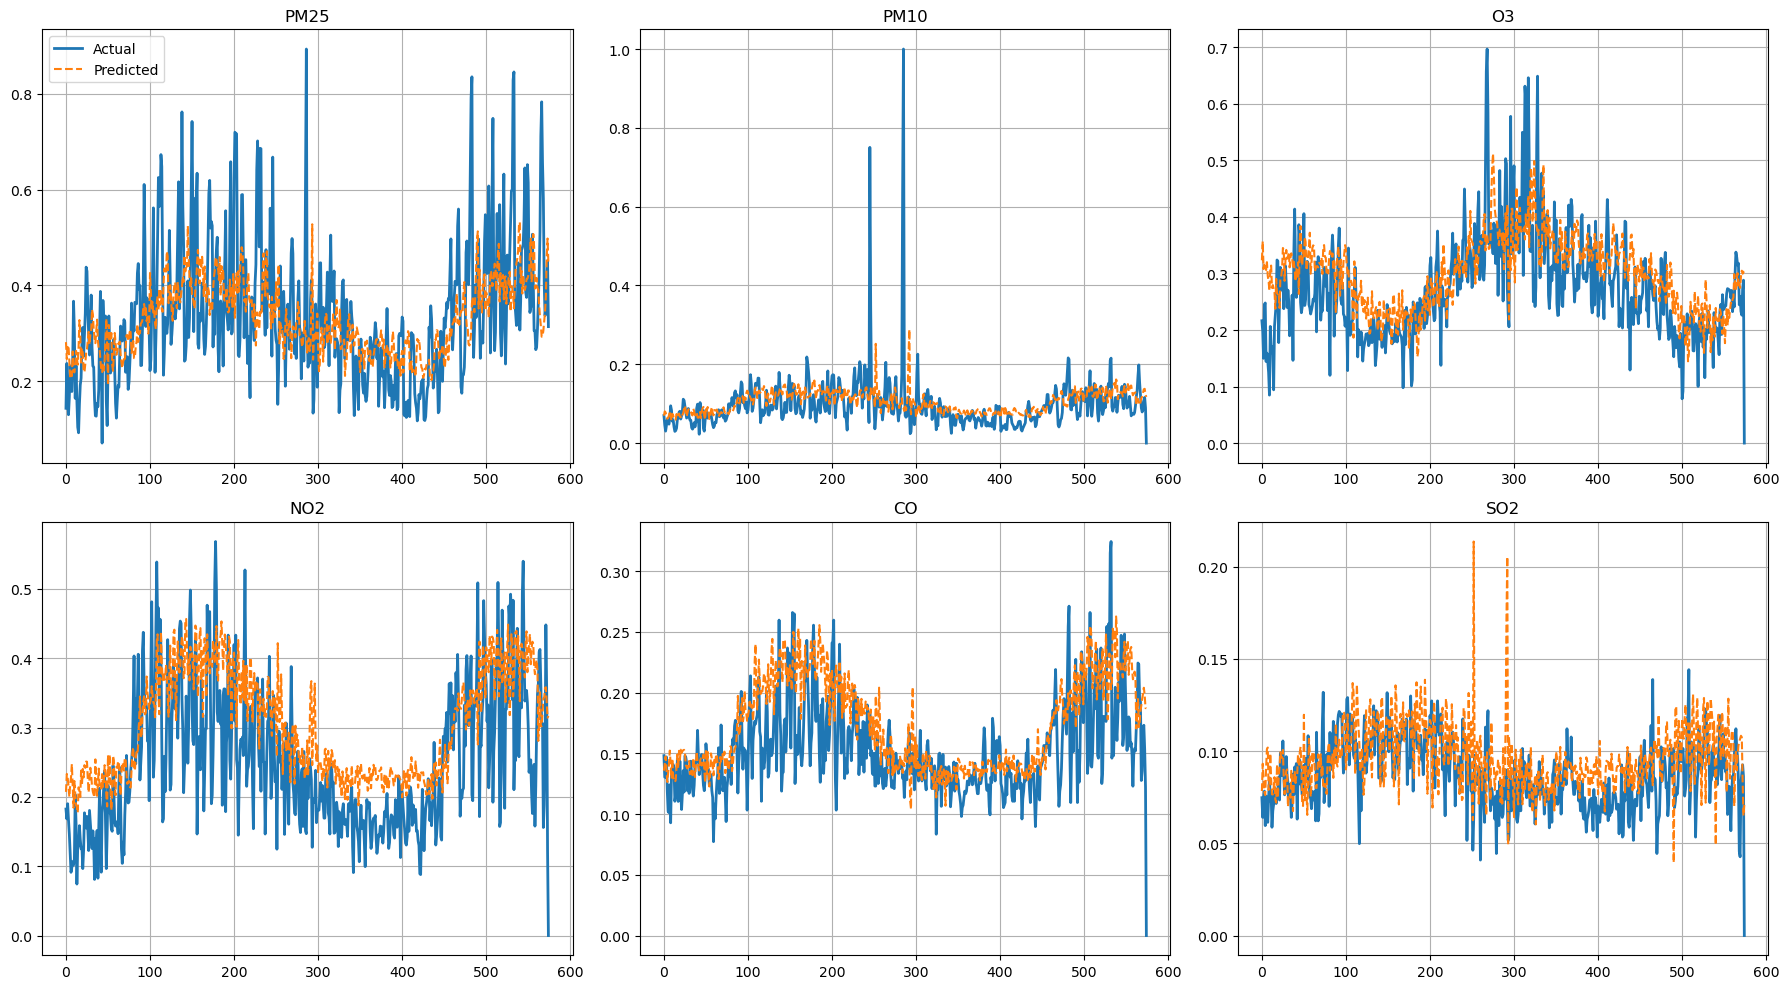

In [ ]:
# TCN + HPO Setup
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import random, math
import matplotlib.pyplot as plt

# Temporal block used in the TCN stack
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        # match input/output channel dims for residual
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        if self.downsample is not None:
            nn.init.kaiming_normal_(self.downsample.weight)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        if out.size(2) > x.size(2):
            out = out[:, :, :x.size(2)]
        elif out.size(2) < x.size(2):
            pad_size = x.size(2) - out.size(2)
            out = nn.functional.pad(out, (0, pad_size))

        res = x if self.downsample is None else self.downsample(x)
        return out + res


# Full TCN model
class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, out_dim, kernel_size=2, dropout=0.2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_ch = num_inputs if i == 0 else num_channels[i-1]
            out_ch = num_channels[i]
            padding = (kernel_size - 1) * dilation_size
            layers.append(
                TemporalBlock(
                    in_ch,
                    out_ch,
                    kernel_size,
                    stride=1,
                    dilation=dilation_size,
                    padding=padding,
                    dropout=dropout
                )
            )
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], out_dim)

    def forward(self, x):
        x = x.transpose(1, 2)
        y = self.network(x)
        # take last time step
        y = y[:, :, -1]
        return self.linear(y)


# Train loop
def train_one(model, loaders, lr=1e-3, epochs=8):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for ep in range(1, epochs + 1):
        model.train()
        tr_loss = []
        for xb, yb in loaders["train"]:
            opt.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            opt.step()
            tr_loss.append(loss.item())

        model.eval()
        val_loss = []
        with torch.no_grad():
            for xb, yb in loaders["val"]:
                preds = model(xb)
                val_loss.append(loss_fn(preds, yb).item())

        print(f"Epoch {ep:02d} | Train MSE={np.mean(tr_loss):.4f} | Val MSE={np.mean(val_loss):.4f}")
    return model


# Evaluate on loader - MAE + RMSE
def eval_model(model, loader):
    model.eval()
    preds, targs = [], []
    with torch.no_grad():
        for xb, yb in loader:
            out = model(xb).detach().numpy()
            preds.append(out)
            targs.append(yb.numpy())
    preds = np.vstack(preds)
    targs = np.vstack(targs)
    mae = mean_absolute_error(targs, preds)
    rmse = math.sqrt(mean_squared_error(targs, preds))
    return mae, rmse


# Random search space for TCN hyperparameters
def random_params():
    return {
        "hidden": random.choice([32, 64, 128]),
        "layers": random.choice([1, 2, 3]),
        "drop":   random.choice([0.0, 0.2, 0.4]),
        "lr":     random.choice([1e-2, 5e-3, 1e-3]),
        "batch":  random.choice([32, 64, 128])
    }


# HPO for TCN
def hpo_tcn(df_daily, trials=30, window=30, horizon=7):
    best_rmse = float("inf")
    best_mae = float("inf")
    best_params = None
    best_state = None

    for t in range(1, trials + 1):
        params = random_params()
        print(f"\n=== TCN Trial {t}/{trials} ===")
        print(params)

        loaders, in_dim, out_dim = make_loaders(df_daily, window, horizon, params["batch"])
        num_channels = [params["hidden"]] * params["layers"]
        model = TCN(num_inputs=in_dim, num_channels=num_channels, out_dim=out_dim, dropout=params["drop"])

        train_one(model, loaders, lr=params["lr"], epochs=10)
        val_mae, val_rmse = eval_model(model, loaders["val"])
        print("Val MAE:", val_mae)
        print("Val RMSE:", val_rmse)

        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_mae = val_mae
            best_params = params
            best_state = model.state_dict()

    print("\n=== Best TCN Params ===")
    print(best_params)
    print("Best Validation RMSE:", best_rmse)
    print("Best Validation MAE:", best_mae)

    # retrain best model
    loaders, in_dim, out_dim = make_loaders(df_daily, window, horizon, best_params["batch"])
    num_channels = [best_params["hidden"]] * best_params["layers"]
    best_model = TCN(num_inputs=in_dim, num_channels=num_channels, out_dim=out_dim, dropout=best_params["drop"])
    best_model.load_state_dict(best_state)

    train_one(best_model, loaders, lr=best_params["lr"], epochs=20)
    test_mae, test_rmse = eval_model(best_model, loaders["test"])
    print("\nFinal Test MAE:", test_mae)
    print("Final Test RMSE:", test_rmse)

    return best_model, best_params, best_rmse, best_mae


# Run HPO for TCN
best_tcn, tcn_params, tcn_rmse, tcn_mae = hpo_tcn(
    df_daily,
    trials=30,
    window=30,
    horizon=7
)
print("\nSelected TCN Params:", tcn_params)
print("Best Validation RMSE:", tcn_rmse)
print("Best Validation MAE:", tcn_mae)


# Plot all pollutants for TCN
def plot_all_pollutants_tcn(best_model, df_daily, window=30, horizon=7, batch=64):
    loaders, in_dim, out_dim = make_loaders(df_daily, window, horizon, batch)
    preds, reals = [], []

    best_model.eval()
    with torch.no_grad():
        for xb, yb in loaders["test"]:
            preds.append(best_model(xb).detach().numpy())
            reals.append(yb.numpy())

    preds = np.vstack(preds)
    reals = np.vstack(reals)

    names = df_daily.columns
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i in range(6):
        ax = axes[i]
        ax.plot(reals[:, i], label="Actual", linewidth=2)
        ax.plot(preds[:, i], label="Predicted", linestyle="dashed")
        ax.set_title(names[i].upper())
        ax.grid(True)

    axes[0].legend()
    plt.tight_layout()
    plt.show()
    return preds, reals


preds_tcn, reals_tcn = plot_all_pollutants_tcn(
    best_tcn, df_daily, window=30, horizon=7, batch=tcn_params["batch"]
)


# Transformer Model + HPO

In [ ]:

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import random
import math

# Configuration
WINDOW = 30
HORIZON = 7
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(f"Using device: {DEVICE}")

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(42)

# --------------------------
# Dataset & Data Loaders
# --------------------------
class MultiStepDataset(Dataset):
    """Dataset for multi-step forecasting (predicts all days in horizon)."""
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]


def create_multistep_loaders(df_daily, window=30, horizon=7, batch_size=64):
    """Create train/val/test loaders for multi-step forecasting (70/10/20 split)."""
    data = df_daily.values
    X, y = [], []

    for i in range(len(data) - window - horizon + 1):
        X.append(data[i:i + window])
        y.append(data[i + window:i + window + horizon])

    X = np.array(X)
    y = np.array(y)

    n = len(X)
    train_end = int(n * 0.7)
    val_end = int(n * 0.8)

    loaders = {
        "train": DataLoader(MultiStepDataset(X[:train_end], y[:train_end]),
                           batch_size=batch_size, shuffle=True),
        "val": DataLoader(MultiStepDataset(X[train_end:val_end], y[train_end:val_end]),
                         batch_size=batch_size, shuffle=False),
        "test": DataLoader(MultiStepDataset(X[val_end:], y[val_end:]),
                          batch_size=batch_size, shuffle=False)
    }

    return loaders, X.shape[-1], y.shape[1], y.shape[2]


def train_multistep_model(model, loaders, lr=1e-3, epochs=20, verbose=True, device='cpu'):
    """Unified training loop for multi-step models."""
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, epochs + 1):
        model.train()
        train_losses = []
        for xb, yb in loaders["train"]:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in loaders["val"]:
                xb, yb = xb.to(device), yb.to(device)
                val_losses.append(loss_fn(model(xb), yb).item())

        history["train_loss"].append(np.mean(train_losses))
        history["val_loss"].append(np.mean(val_losses))

        if verbose and epoch % 5 == 0:
            print(f"Epoch {epoch:02d} | Train MSE: {np.mean(train_losses):.4f} | Val MSE: {np.mean(val_losses):.4f}")

    return model, history


def evaluate_multistep_model(model, loader, pollutant_names=None, device='cpu'):
    """Evaluate multi-step model and return predictions, actuals, and metrics."""
    model = model.to(device)
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            preds.append(model(xb).cpu().numpy())
            targets.append(yb.numpy())

    preds = np.concatenate(preds, axis=0)
    targets = np.concatenate(targets, axis=0)

    preds_flat = preds.reshape(-1, preds.shape[-1])
    targets_flat = targets.reshape(-1, targets.shape[-1])

    mae = mean_absolute_error(targets_flat, preds_flat)
    rmse = math.sqrt(mean_squared_error(targets_flat, preds_flat))

    per_pollutant = {}
    if pollutant_names:
        for i, name in enumerate(pollutant_names):
            per_pollutant[name] = {
                "mae": mean_absolute_error(targets_flat[:, i], preds_flat[:, i]),
                "rmse": math.sqrt(mean_squared_error(targets_flat[:, i], preds_flat[:, i]))
            }

    return {
        "predictions": preds,
        "actuals": targets,
        "mae": mae,
        "rmse": rmse,
        "per_pollutant": per_pollutant
    }


# --------------------------
# Transformer Architecture
# --------------------------
class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding for Transformer."""
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 0:
            pe[:, 1::2] = torch.cos(position * div_term)
        else:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class TransformerMultiStep(nn.Module):
    """Transformer encoder for multi-step time series forecasting."""
    def __init__(self, in_dim, d_model, nhead, num_layers, horizon, out_dim, dropout=0.1):
        super().__init__()
        self.horizon = horizon
        self.out_dim = out_dim

        self.input_proj = nn.Linear(in_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(d_model, horizon * out_dim)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x[:, -1, :]
        x = self.output_proj(x)
        return x.view(-1, self.horizon, self.out_dim)


def hpo_transformer(df_daily, trials=30, window=30, horizon=7, device='0'):
    best_rmse, best_params, best_model = float("inf"), None, None

    for t in range(1, trials + 1):
        d_model = random.choice([32, 64, 128])
        possible_heads = [h for h in [2, 4, 8] if d_model % h == 0]
        nhead = random.choice(possible_heads)

        params = {
            "d_model": d_model,
            "nhead": nhead,
            "num_layers": random.choice([1, 2, 3]),
            "dropout": random.choice([0.0, 0.1, 0.2]),
            "lr": random.choice([1e-3, 5e-4, 1e-4]),
            "batch": random.choice([32, 64, 128])
        }
        print(f"\n=== Transformer Trial {t}/{trials} === d_model={d_model}, nhead={nhead}, layers={params['num_layers']}")

        loaders, in_dim, horizon_len, out_dim = create_multistep_loaders(df_daily, window, horizon, params["batch"])
        model = TransformerMultiStep(
            in_dim, params["d_model"], params["nhead"], params["num_layers"],
            horizon_len, out_dim, params["dropout"]
        )
        model, _ = train_multistep_model(model, loaders, lr=params["lr"], epochs=10, verbose=False, device=device)

        results = evaluate_multistep_model(model, loaders["val"], device=device)
        print(f"Val RMSE: {results['rmse']:.4f}")

        if results["rmse"] < best_rmse:
            best_rmse, best_params, best_model = results["rmse"], params, model

    print(f"\n{'='*50}\nBEST Transformer: {best_params}\nVal RMSE: {best_rmse:.4f}\n{'='*50}")

    loaders, in_dim, horizon_len, out_dim = create_multistep_loaders(df_daily, window, horizon, best_params["batch"])
    best_model = TransformerMultiStep(
        in_dim, best_params["d_model"], best_params["nhead"], best_params["num_layers"],
        horizon_len, out_dim, best_params["dropout"]
    )
    best_model, history = train_multistep_model(best_model, loaders, lr=best_params["lr"], epochs=30, device=device)

    return best_model, best_params, history


# Run Transformer HPO
print("Training Transformer with Hyperparameter Optimization...")
transformer_model, transformer_params, transformer_history = hpo_transformer(
    df_daily, trials=30, window=WINDOW, horizon=HORIZON, device=DEVICE
)

# Evaluate on test set
transformer_loaders, _, _, _ = create_multistep_loaders(df_daily, WINDOW, HORIZON, transformer_params["batch"])
transformer_results = evaluate_multistep_model(transformer_model, transformer_loaders["test"], pollutants, device=DEVICE)

print(f"\nTransformer TEST RESULTS (7-day forecast)")
print(f"MAE:  {transformer_results['mae']:.4f}")
print(f"RMSE: {transformer_results['rmse']:.4f}")

False
Using device: cpu
Training Transformer with Hyperparameter Optimization...

=== Transformer Trial 1/30 === d_model=128, nhead=2, layers=1
Val RMSE: 0.0735

=== Transformer Trial 2/30 === d_model=32, nhead=2, layers=3
Val RMSE: 0.1075

=== Transformer Trial 3/30 === d_model=128, nhead=2, layers=3
Val RMSE: 0.0744

=== Transformer Trial 4/30 === d_model=32, nhead=2, layers=1
Val RMSE: 0.0977

=== Transformer Trial 5/30 === d_model=128, nhead=2, layers=3
Val RMSE: 0.0926

=== Transformer Trial 6/30 === d_model=64, nhead=2, layers=2
Val RMSE: 0.0699

=== Transformer Trial 7/30 === d_model=32, nhead=8, layers=2
Val RMSE: 0.0786

=== Transformer Trial 8/30 === d_model=32, nhead=4, layers=1
Val RMSE: 0.0764

=== Transformer Trial 9/30 === d_model=64, nhead=4, layers=3
Val RMSE: 0.0756

=== Transformer Trial 10/30 === d_model=64, nhead=8, layers=1
Val RMSE: 0.0804

=== Transformer Trial 11/30 === d_model=64, nhead=8, layers=3
Val RMSE: 0.0875

=== Transformer Trial 12/30 === d_model=128,

# Comparison

MODEL COMPARISON SUMMARY
      Model    MAE   RMSE                                                 Best Hyperparameters
       LSTM 0.0416 0.0661                    hidden=64, layers=1, drop=0.4, lr=0.001, batch=32
        GRU 0.0415 0.0658                    hidden=32, layers=3, drop=0.0, lr=0.001, batch=32
        TCN 0.0446 0.0689                     hidden=32, layers=3, drop=0.2, lr=0.01, batch=32
Transformer 0.0440 0.0687 d_model=128, nhead=4, num_layers=3, dropout=0.0, lr=0.0001, batch=32


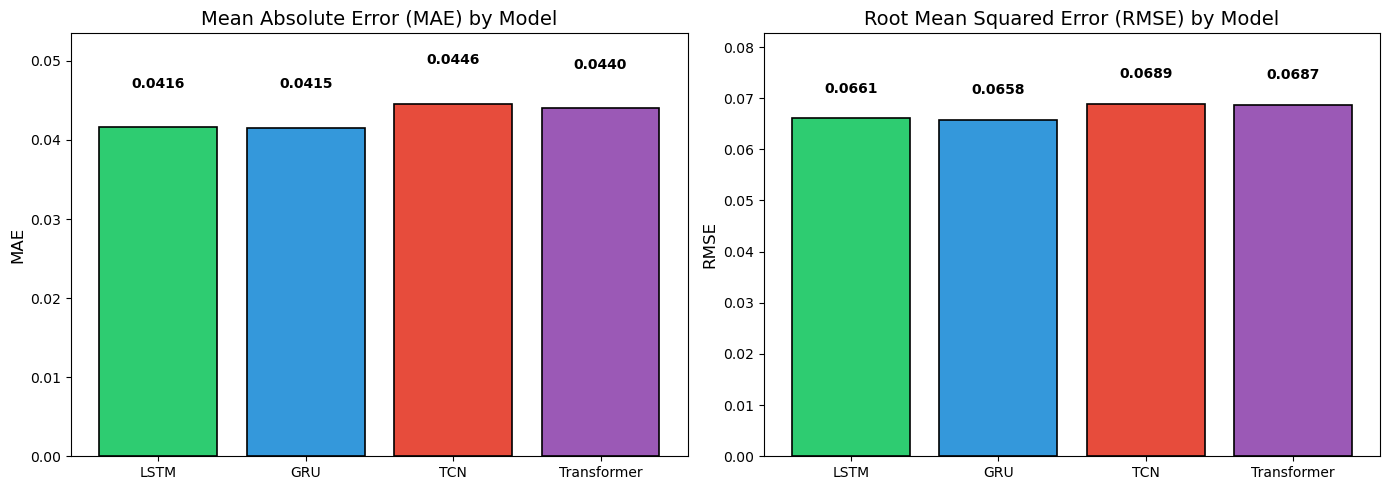


 BEST MODEL: GRU
   MAE:  0.0415
   RMSE: 0.0658


In [26]:
# =========================================================
# MODEL COMPARISON - Summary Table & Visualizations
# =========================================================

import pandas as pd
import matplotlib.pyplot as plt

# --------------------------
# 1. Collect all results
# --------------------------
# Note: LSTM, GRU, TCN return (model, params, rmse, mae)
# Transformer returns results dict with 'mae', 'rmse', 'per_pollutant', etc.

model_results = {
    "LSTM": {
        "model": best_model,
        "params": best_params,
        "mae": best_val_mae,
        "rmse": best_val_rmse
    },
    "GRU": {
        "model": best_gru,
        "params": gru_params,
        "mae": gru_mae,
        "rmse": gru_rmse
    },
    "TCN": {
        "model": best_tcn,
        "params": tcn_params,
        "mae": tcn_mae,
        "rmse": tcn_rmse
    },
    "Transformer": {
        "model": transformer_model,
        "params": transformer_params,
        "mae": transformer_results['mae'],
        "rmse": transformer_results['rmse']
    }
}

# --------------------------
# 2. Summary Table
# --------------------------
summary_data = []
for name, data in model_results.items():
    params_str = ", ".join([f"{k}={v}" for k, v in data["params"].items()])
    summary_data.append({
        "Model": name,
        "MAE": f"{data['mae']:.4f}",
        "RMSE": f"{data['rmse']:.4f}",
        "Best Hyperparameters": params_str
    })

summary_df = pd.DataFrame(summary_data)
print("=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print(summary_df.to_string(index=False))
print("=" * 80)

# --------------------------
# 3. Bar Charts - MAE & RMSE Comparison
# --------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

model_names = list(model_results.keys())
maes = [model_results[m]["mae"] for m in model_names]
rmses = [model_results[m]["rmse"] for m in model_names]
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

# MAE Bar Chart
axes[0].bar(model_names, maes, color=colors, edgecolor='black', linewidth=1.2)
axes[0].set_ylabel('MAE', fontsize=12)
axes[0].set_title('Mean Absolute Error (MAE) by Model', fontsize=14)
axes[0].set_ylim(0, max(maes) * 1.2)
for i, v in enumerate(maes):
    axes[0].text(i, v + 0.005, f'{v:.4f}', ha='center', fontsize=10, fontweight='bold')

# RMSE Bar Chart
axes[1].bar(model_names, rmses, color=colors, edgecolor='black', linewidth=1.2)
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].set_title('Root Mean Squared Error (RMSE) by Model', fontsize=14)
axes[1].set_ylim(0, max(rmses) * 1.2)
for i, v in enumerate(rmses):
    axes[1].text(i, v + 0.005, f'{v:.4f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# --------------------------
# 4. Best Model Highlight
# --------------------------
best_model_name = min(model_results.keys(), key=lambda m: model_results[m]["rmse"])
best_rmse_val = model_results[best_model_name]["rmse"]
best_mae_val = model_results[best_model_name]["mae"]

print(f"\n BEST MODEL: {best_model_name}")
print(f"   MAE:  {best_mae_val:.4f}")
print(f"   RMSE: {best_rmse_val:.4f}")